In [2]:
from PreFRBLE.convenience import *
from PreFRBLE.estimate_redshift import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *

In [3]:
scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18/smd'],
    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
}

scenario_IGM = {
    'IGM' : ['primordial'],
}

Cs = np.arange(0.500,1.300, 0.100)


In [114]:
from matplotlib.colors import LogNorm
    ## make contour plot to compare all bayes factors at once
def PlotBayes2D( bayes=[], x=[], y=[], x_labels=None, y_labels=None, xlabel=None, ylabel=None, likelihood_min=1e-5, extent=[0,30,0,50] ):
    """
    plot Bayes factors of an evenly distributed 2D parameter space
    
    
    
    Parameters
    ----------
    bayes : array_like
        bayes factors 
    x,y : array_like, shape( bayes.shape[i] ), i=0,1 for x,y respectively
        value of x & y parameters corresponding to bayes factor
    (x/y)_labels : list, optional
        list of labels attached to tick values
    likelihood_min : float
        minimal likelihood to be displayed. all values below this limit will have same color in final plot. 
        Used to pronounce the interesting values of bayes
        
    
    """


    ## levels used for Colorbar
    levels = 10.**np.linspace( np.log10(likelihood_min), 0, 200 )
        
    plt.imshow( bayes[::-1]/bayes.max(), cmap=rainbow, extent=extent, norm=LogNorm( vmin=likelihood_min) )
    
    plt.xticks( [5,15,25], populations )
    x_off = float(extent[1])/len(x)/2
    plt.xticks( np.linspace(x_off,50-x_off,len(x)), x_labels if x_labels else x)
    y_off = float(extent[-1])/len(y)/2
    plt.yticks( np.linspace(y_off,50-y_off,len(y)), y_labels if y_labels else y)
    
                                
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    Colorbar( np.log10(levels), label=r"log$_{10}\left(\mathcal{B}/\mathcal{B}_{\rm max}\right)$" )
    plt.show()
    

In [115]:
def LikelihoodsDM_PopulationTelescope( scenario={}, C=1., population='SMD', telescope='Parkes', FRBs=None, plot_distribution=False, ax=None, **kwargs ):
    """ 
    obtain likelihoods of DM of FRBs observed by telescope, assuming cosmic population and DM-redshift ratio C*1000 pc cm^-3 
    
    optionally plot the distribution of DM expected to be observed by telescope in this scenario
    """
    
    ### choose correct scenario
    tmp = scenario.copy()
    tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]

    ## obtain prediction for distribution of DM observed by telescope
    P, x = GetLikelihood_Telescope( measure='DM', telescope=telescope, population=population, **tmp )

    ## if desired, plot the distribution of DM expected to be observed by telescope in this scenario
    if plot_distribution:
        if ax is None:
            fig, ax = plt.subplots()
        PlotLikelihood( x=x, P=P, measure='DM', ax=ax, **kwargs)
        ax.set_ylim(1e-5,1)
        ax.set_title( "%s with %s, assuming DM$/z = %i$ pc cm$^{-3}$" % ( population, telescope, np.round(C*1000,-2) ) )

    if FRBs is None:
        FRBs = GetFRBcat( telescopes=[telescope])
        
    # compute and return likelihood of DM in FRBcat according to this prediction    
    return Likelihoods( measurements=FRBs['DM']-FRBs['DM_gal'], P=P, x=x )


In [116]:
def LikelihoodsC_PopulationTelescope( scenario={}, population='SMD', telescope='Parkes', FRBs=None, plot_distribution=False, ax=None ):
    """ obtain likelihood of C \propto DM/redshift, based on how well distribution of DM as observed by telescope resembles expectation according to population """
    
    likelihoods = []
    if FRBs is None:
        FRBs = GetFRBcat( telescopes=[telescope] )
    
    if plot_distribution:
        if ax is None:
            fig, ax = plt.subplots()

    ## copmute likelihoods for each value of C
    for C, color in zip( Cs, Rainbow(Cs) ):
        likelihoods.append( LikelihoodsDM_PopulationTelescope( C=C, FRBs=FRBs, population=population, telescope=telescope, plot_distribution=plot_distribution, ax=ax, color=color ) )
        
    if plot_distribution:
        ax.set_title( "%s with %s, assuming DM$ = C 1000z$ pc cm$^{-3}$" % ( population, telescope ) )
        Colorbar( Cs, label='C' )
    ## return raw likelihoods    
    return np.array(likelihoods)

In [117]:

def BayesC_PopulationTelescope( scenario={}, population='SMD', telescope='Parkes', plot_bayes=False, plot_distribution=False, ax=None, **kwargs):
    """ 
    obtain Bayes factor of C propto DM/z inferred from DM of FRBs observed with telescope, assuming population
    
    optionally plot the resulting bayes factor
    """
    
    
    ## compute  likelihood for all choices of C
    likelihoods = LikelihoodsC_PopulationTelescope( population=population, telescope=telescope, plot_distribution=plot_distribution )
    N_FRBs = likelihoods.shape[1]
    
    ## compute total Bayes factor = product of likelihoods renormalized to one choice of C
    bayes = np.prod( likelihoods / likelihoods[0].reshape(1,N_FRBs), axis=1 )

    if plot_bayes:
        if ax is None:
            fig, ax = plt.subplots()
                               
        PlotBayes( x=Cs, y=bayes, label='C', width=0.03, ax=ax, title=r"%s with %s, $N_{FRBs} = %i$" % (population, telescope, N_FRBs), **kwargs )
    return bayes
                            

In [118]:
def PlotBayesC_Population( scenario={}, population='SMD', plot_bayes_telescope=False, plot_distribution=False, **kwargs):
    """ obtain Bayes factor of C propto DM/z inferred from DM of FRBs observed by any of telescopes, assuming population """
    
    bayes = []
    if plot_bayes_telescope:
        fig, axs = plt.subplots(1,len(telescopes),figsize=(4*len(telescopes),3))
    else:
        axs = [None]*len(telescopes)
        
    ## obtain bayes factors of C for each telescope
    for telescope, ax in zip( telescopes, axs ):
        bayes.append( BayesC_PopulationTelescope( population=population, telescope=telescope, plot_bayes=plot_bayes_telescope, plot_distribution=plot_distribution, ax=ax ) )
    if plot_bayes_telescope:
        plt.tight_layout()
        
    ## multiply results
    bayes = np.prod(bayes, axis=0)
    
    ## plot final likelihood estimate
    PlotBayes( x=Cs, y=bayes, label='C', width=0.03, title=population, **kwargs )


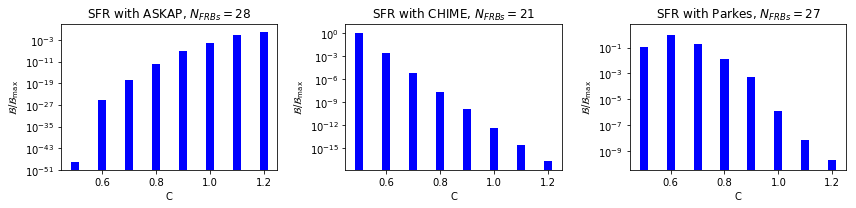

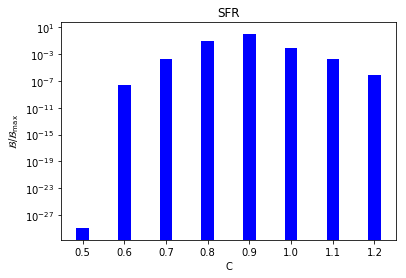

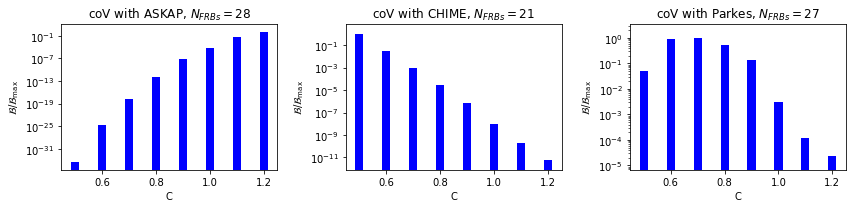

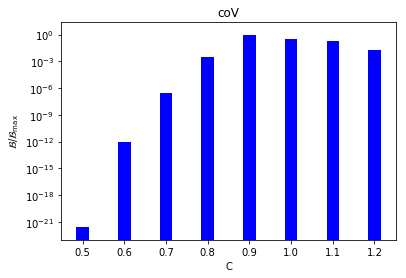

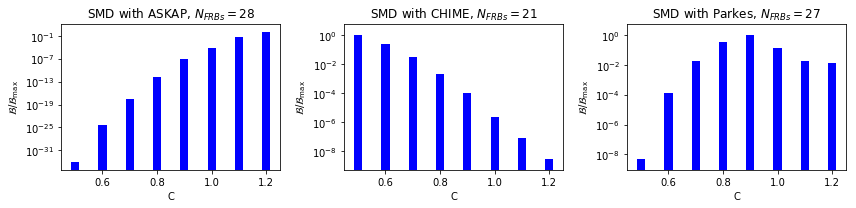

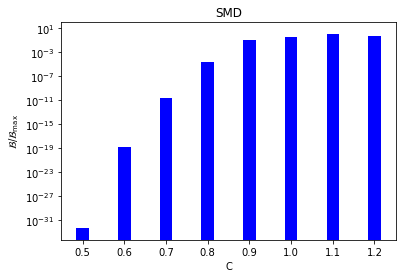

In [120]:
for population in populations:
    PlotBayesC_Population( scenario=scenario, population=population, plot_bayes_telescope=True )

Find fit for results of primordial IGM model with DM $ = C \times z \times 1000 \rm~ pc~ cm^{-3}$

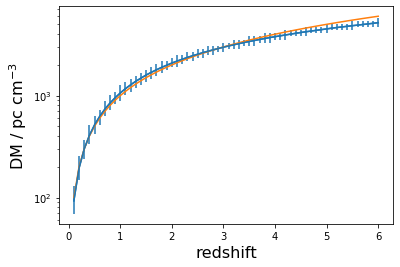

In [12]:
PlotAverageEstimate( measure='DM', scenario=scenario_IGM)

C_primordial = 1

plt.plot( redshift_bins, redshift_bins*1000*C_primordial )




compute IGM likelihoods for other choices of $C$

In [14]:

for C in Cs:
    for z in redshift_bins:
#        fig, ax = plt.subplots()
        P, x = GetLikelihood_Full( measure='DM', redshift=z, **scenario_IGM)
#        PlotLikelihood( x=x, P=P, measure='DM', ax=ax)
        P, x = LikelihoodShift( P=P, x=x, shift=C )
#        print( np.sum(P*np.diff(x)) )
#        PlotLikelihood( x=x, P=P, measure='DM', ax=ax)
#        print( [ KeyIGM( redshift=z, measure='DM', model="%s_C%.0f" % ( scenario_IGM['IGM'][0], C*1000 ) , axis=axis  ) for axis in ['P','x'] ])
        Write2h5( likelihood_file_IGM, datas=[P,x], keys=[ KeyIGM( redshift=z, measure='DM', model="%s_C%.0f" % ( scenario_IGM['IGM'][0], C*1000 ) , axis=axis  ) for axis in ['P','x'] ] )
        
        
#        plt.show()



plot redshift evolution of $\langle$DM$\rangle$

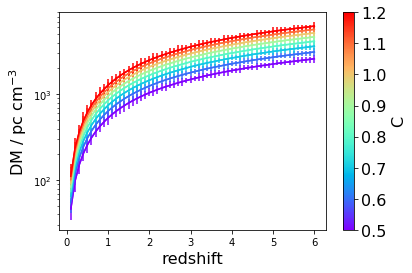

In [18]:
fig, ax = plt.subplots()

for C, color in zip( Cs, Rainbow(Cs) ):
    tmp = scenario_IGM.copy()
    tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]
    PlotAverageEstimate( measure='DM', scenario=tmp, ax=ax, color=color )
Colorbar(Cs, label='C')

make redshift estimates for a given scenario

In [4]:
## choose scenario with different DM-redshift-relation
C=0.7
tmp = scenario.copy()
tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]

## estimate redshifts, considering selection effects of telescopes and assuming different cosmic populations as prior likelihood
## results are written to npy file, FilenameEstimatedRedshift( tmp )
FRBcatEstimateRedshifts( scenario=tmp )

In [6]:
## read estimated redshifts of scenario into structured numpy array
redshift_estimates = GetEstimatedRedshifts( scenario=tmp )

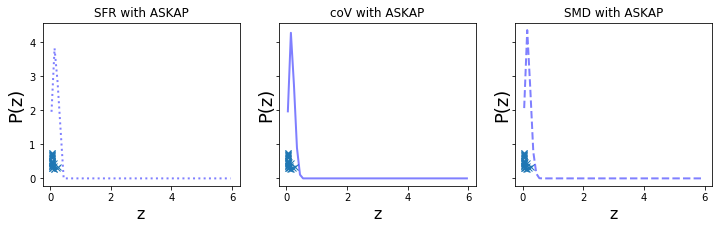

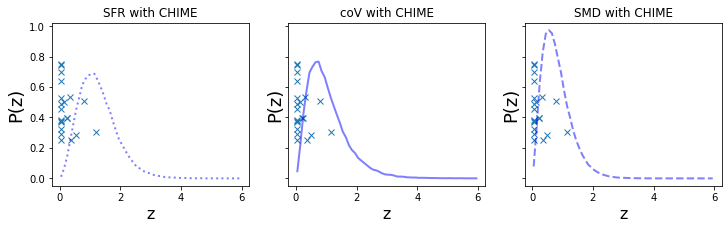

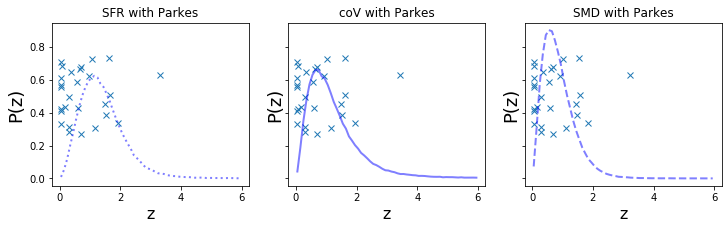

In [7]:
### see how well the obtained redshifts compare to assumed population
### compare shape of likelihood function and compute Bayes factor

#FRBs = GetFRBcat(telescopes=telescopes)

likelihoods = np.zeros( [len(redshift_estimates), len(populations)] )


for tele in telescopes:
    ix_tele, = np.where( redshift_estimates['telescope'] == tele )

#    ix_tele, = np.where( FRBs['tele'] == telescopes_FRBcat[tele] )
#    fig, ax = plt.subplots()
#    ax.set_title( tele ) #"%s with %s" % (pop, tele) )
#    ax.plot( redshift_estimates[ix_tele,-2], 0.75-0.5*np.random.rand(len(ix_tele)), marker='x', linestyle=' ' )

    fig, axs = plt.subplots(1,3,figsize=(12,3), sharey=True)
    y_FRBs = 0.75-0.5*np.random.rand(len(ix_tele))
    
#    for ipop, (pop, linestyle) in enumerate(zip(populations, linestyles_population)):

    for ipop, (pop, linestyle, ax) in enumerate(zip(populations, linestyles_population, axs)):
        estimates = redshift_estimates['redshift'+pop]
        ax.set_title( "%s with %s" % (pop, tele) )
        ax.plot( estimates[ix_tele], y_FRBs, marker='x', linestyle=' ' )
#        ax.plot( estimates[ix_tele], y_FRBs, marker='x', linestyle=' ' )

##        P, x = histogram( estimates[ix_tele], bins=60, range=(0,6), log=False, density=True )
##        PlotLikelihood( x=x, P=P, log=False, measure='z', ax=ax, linestyle=linestyle, label=pop, color='black' )
        P, x = GetLikelihood_Redshift( population=pop, telescope=tele )
        PlotLikelihood( x=x, P=P, log=False, label=pop, measure='z', ax=ax, linestyle=linestyle, linewidth=2, alpha=0.5, color='blue' )
    
        likelihoods[ix_tele,ipop] = Likelihoods( measurements=estimates[ix_tele], P=P, x=x )
#    ax.legend()
plt.show()

        
likelihoods /= likelihoods[:,0].repeat( likelihoods.shape[1] ).reshape( *likelihoods.shape )

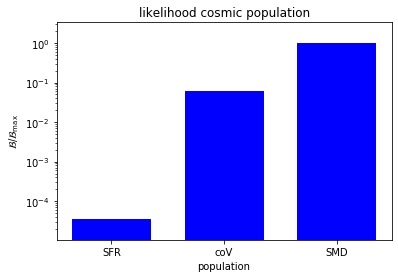

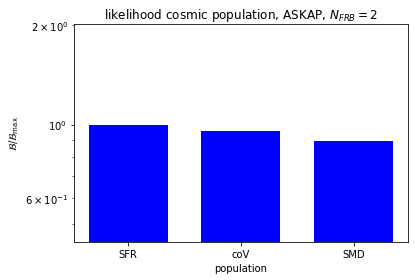

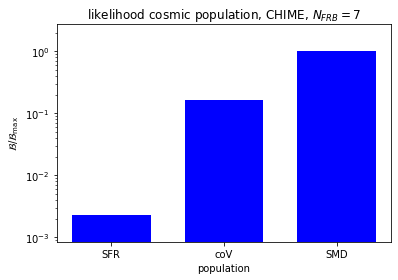

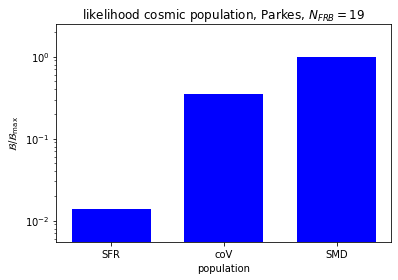

In [12]:

## only use FRBs with reasonable redshift estimates
#ix_reasonable, = np.where(redshift_estimates['redshiftSMD'][ix_tele]<4.5)*(redshift_estimates['redshiftSMD'][ix_tele]>0.05)
ix_reasonable, = np.where( redshift_estimates['redshiftSMD']>0.15 )

#print( likelihoods[ ix_reasonable  ] )
bayes = np.prod( likelihoods[ ix_reasonable  ], axis=0 )

#print(bayes)

PlotBayes( x=populations, y=bayes, width=0.7, label='population', title='likelihood cosmic population' )

plt.show()


for tele in telescopes:
    ix_tele, = np.where( redshift_estimates['telescope'][ix_reasonable] == tele )
    ls = likelihoods[ix_reasonable[ix_tele]]
#    print(ls)
    bayes = np.prod( ls, axis=0 )
#    bayes = np.prod( likelihoods[ (redshift_estimates[:,0]<4.5)*(redshift_estimates[:,0]>0.05)  ], axis=0 )
    PlotBayes( x=populations, y=bayes, width=0.7, label='population', title='likelihood cosmic population, %s, $N_{FRB} = %i$' % ( tele, len( ix_tele ) ) )

    plt.show()

In [3]:
def LikelihoodPopulation_( redshift_estimates=[], plot_distribution=False, renormalize=True ):
    """
    compute likelihood of population based on how well redshift estimates resemble expected distribution
    """
    
    
    ## read redshifts of FRBs in FRBcat, estimated assuming scenario
#    redshift_estimates = GetEstimatedRedshifts( scenario )

    ### see how well the obtained redshifts compare to assumed population
    ### compare shape of prior and posterior likelihood function by computing Bayes factors

    likelihoods = np.zeros( [len(redshift_estimates), len(populations)] )

    
    for tele in telescopes:
        
        ## find FRBs observed by this telescope
        ix_tele, = np.where( redshift_estimates['telescope'] == tele )

        if plot_distribution:
            fig, axs = plt.subplots(1,3,figsize=(12,3), sharey=True)
            y_FRBs = 0.75-0.5*np.random.rand(len(ix_tele))
    
        for ipop, (pop, linestyle) in enumerate(zip(populations, linestyles_population)):

            ## get redshift estimates that assume this population
            estimates = redshift_estimates['redshift'+pop]
        
            ## get expected distribution of redshifts
            P, x = GetLikelihood_Redshift( population=pop, telescope=tele )
        
            ## compute the likelihood of estimated redshifts according to expected distribution
            likelihoods[ix_tele,ipop] = Likelihoods( measurements=estimates[ix_tele], P=P, x=x )
    
            if plot_distribution:
                axs[ipop].set_title( "%s with %s" % (pop, tele) )
            
                ## plot estimated redshifts
                axs[ipop].plot( estimates[ix_tele], y_FRBs, marker='x', linestyle=' ' )
            
                ## and their assumed == expected distribution
                PlotLikelihood( x=x, P=P, log=False, label=pop, measure='z', ax=axs[ipop], linestyle=linestyle, linewidth=2, alpha=0.5, color='blue' )
    
        if plot_distribution:
            plt.show()

    if renormalize:
        ## renormlize likelihood to first population -> Bayes factors for population    
        likelihoods /= likelihoods[:,0].repeat( likelihoods.shape[1] ).reshape( *likelihoods.shape )

    return likelihoods


    
def BayesBaryonContent_old( scenario={} ):
    """ 
    compute and plot bayes factor of C in DM = C * z * 1000 pc cm^-3, obtained by comparing how well estimates of redshift of FRBs in FRBcat resemble distribution expected from cosmic population 
    
    !!! ATTENTION !!! by only using estimate of redshift, we ignore uncertainties on that redshift and arrive at artificially precise conclusions.
    !!! DO NOT TRUST RESULTS !!!
    
    """

    likelihoods = []
    
    
    for C in Cs:
        tmp = scenario.copy()
        tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]
        
        redshift_estimates = GetEstimatedRedshifts( tmp )
        
        likelihoods.append( LikelihoodPopulations( redshift_estimates=redshift_estimates, renormalize=False) )

#        ix_reasonable, = np.where( redshift_estimates['redshiftSMD']>0.15 )
#        ixs_reasonable.append( ix_reasonable )

    ix_reasonable, = np.where( redshift_estimates['redshiftSMD']>0.15 )

    ## renormlize likelihoods to first scenario -> Bayes factors for scenarios
    likelihoods = np.array(likelihoods)
    likelihoods = likelihoods / likelihoods[0]#.reshape( [likelihoods.shape[0], likelihoods.shape[1], len(Cs)] )
    
    print(likelihoods.shape)
    
    bayes = np.prod( likelihoods, axis=1 )
    for ipop, population in enumerate( populations ):
        PlotBayes( x=Cs, y=bayes[:,ipop], width=0.03, label='C', title=population+', likelihood DM=$C$ $z$ 1000 pc cm$^{-3}$')
        plt.show()
        
        
    ## make contour plot to compare all bayes factors at once
    
    x = np.linspace(0.5,1.3,len(Cs))
    y = np.arange(-1,2)                                
    xy_x, xy_y = np.meshgrid( y, x )
                                 
    lvl_min = 1e-5
    levels = np.linspace( np.log10(lvl_min), 0, 200 )
    colors = Rainbow( levels )
    levels = 10.**levels
    from matplotlib.colors import LogNorm
        
    plt.imshow( bayes[::-1]/bayes.max(), cmap=rainbow, extent=[0,30,0,50], norm=LogNorm( vmin=1e-5) )
    plt.xticks( [5,15,25], populations )
    off = float(50)/len(Cs)/2
    plt.yticks( np.linspace(off,50-off,len(Cs)), np.round(Cs,1) )
    
    print(bayes/bayes.max())
                                
#    plt.contourf(xy_x, xy_y, bayes/bayes.max(), levels, colors=colors )
#    plt.xticks( y*2/4, populations )
    plt.ylabel('C')
    Colorbar( np.log10(levels), label=r"log$_{10}\left(\mathcal{B}/\mathcal{B}_{\rm max}\right)$" )
    plt.show()
    
                                 
                                 

(8, 76, 3)


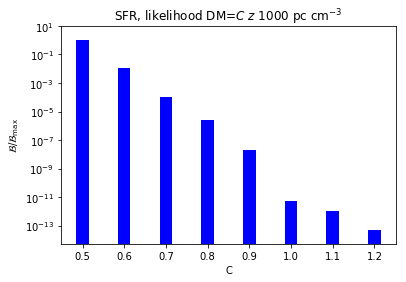

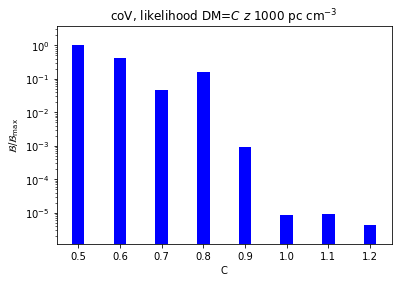

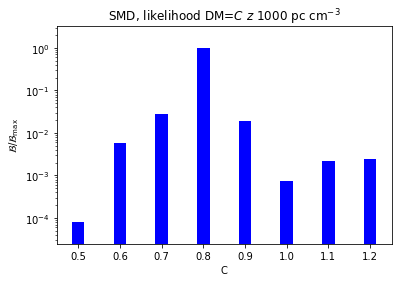

[[7.93186825e-05 7.93186825e-05 7.93186825e-05]
 [9.03976958e-07 3.40931395e-05 5.67937620e-03]
 [7.98379278e-09 3.61090440e-06 2.72608613e-02]
 [2.12863387e-10 1.23575920e-05 1.00000000e+00]
 [1.68128596e-12 7.26028410e-08 1.89345964e-02]
 [4.23419673e-16 6.78535101e-10 7.45644585e-04]
 [8.28407336e-17 7.21171363e-10 2.17851738e-03]
 [4.02293970e-18 3.44465765e-10 2.48202505e-03]]


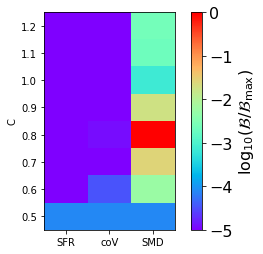

In [4]:
BayesBaryonContent( scenario )

joint investigation of IGM baryon content and redshift population of FRBs.
Using prediction of $P(z|{\rm telescope},{\rm population})$ and $P({\rm DM}|z,C)$, we arrive at prediction of observed DM by integration, $P({\rm DM}|C,{\rm telescope},{\rm population}) = \int P(z|{\rm telescope},{\rm population}) ~ P({\rm DM}|z,C) ~{\rm d}z$ and quantify how well that fits to $P(DM|{\rm observed})$.

In [168]:
def LikelihoodDM( scenario={}, telescope='Parkes', population='SMD', FRBs=None, DMs=None, plot=False, plot_FRBs=False, ax=None, label=None ):
    """ 
    returns likelihood of values of DM observed by telescope for the case of scenario and population
    
    Parameters
    ----------
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
    
    Returns
    -------
    likelihoods : array-like
        1D array with likelihoods of individual DM observed by telescope  
    """
    ## read likelihood of redshifts
    P_z, z = GetLikelihood_Redshift( population=population, telescope=telescope )
    
    ## read likleihood of DM at different redshift expected in scenario
    Ps, xs = [], []
    for redshift in redshift_bins:
        P, x = GetLikelihood_Full( measure='DM', redshift=redshift, **scenario)
        Ps.append(P)
        xs.append(x)
    ## compute prediction for distribution of observed DM
    P_DM, DM = LikelihoodsAdd( Ps=Ps, xs=xs, weights=P_z*np.diff(z) )
        
    if DMs is None:
        ## read observed values of extragalactic DM
        if FRBs is None:
            FRBs = GetFRBcat( telescopes=[telescope] )
        DMs = FRBs['DM']-FRBs['DM_gal']
    
    if plot:
        if ax is None:
            fig, ax = plt.subplots()
        ax.set_title( ("%s with %s" % (population, telescope)) )
        PlotLikelihood( P=P_DM, x=DM, measure='DM', ax=ax, label=label )
        if plot_FRBs:
            y_DMs = 0.75-0.5*np.random.rand(len(DMs))
            ax.plot( DMs, y_DMs, marker='x', linestyle=' ' )
        
    ## compute likelihood of observation
    likelihoods = Likelihoods( measurements=DMs, P=P_DM, x=DM )
    return likelihoods

def LikelihoodBaryonContent( Cs=Cs, scenario={}, telescope='Parkes', population='SMD', FRBs=None, DMs=None ):
    """ 
    returns likelihood of values of C in DM_EG = C*z*1000 pc cm^-3, that present different IGM baryon contents.
    Likelihoods are quantified by how well DM observed by telescope agree with predictions for the case of scenario and population
    
    Parameters
    ----------
    Cs : array-like
        possible values of C
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
        
    Returns
    -------
    likelihoods : array-like
        2D array with likelihoods of values of C according to individual DM observed by telescope
    """
    
    if FRBs is None:
        FRBs = GetFRBcat( telescopes=[telescope] )
    
    likelihoods = []
    for C in Cs:
        tmp = scenario.copy()
        tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]
        likelihoods.append( LikelihoodDM( scenario=tmp, telescope=telescope, population=population, FRBs=FRBs, DMs=DMs ))
    likelihoods = np.array( likelihoods )
        
    return likelihoods
    
    

def BayesBaryonContentPopulationTelescope( scenario={}, telescope='Parkes', Cs=Cs, populations=populations, plot=False, DMs=None):
    """ 
    returns joint likelihood of FRB populations and values of C in DM_EG = C*z*1000 pc cm^-3, that present different IGM baryon contents.
    Likelihoods are quantified by how well DM observed by telescope agree with predictions for the case of scenario and population
    
    Parameters
    ----------
    Cs : array-like
        possible values of C
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
        
    Returns
    -------
    likelihoods : array-like
        2D array with likelihoods of tuples of FRB populations and values of C according to individual DM observed by telescope
    """
    
    FRBs = GetFRBcat( telescopes=[telescope] )

    ## for each population, obtain the likelihoods of values of C for individual DM observed by telescope
    likelihoods = []
    for population in populations:
        likelihoods.append( LikelihoodBaryonContent(  Cs=Cs, FRBs=FRBs, DMs=DMs, population=population, telescope=telescope, scenario=scenario ) )
    likelihoods = np.array( likelihoods )  # 3D array (N_pop, N_Cs, N_FRBs)
    
    ## obtain bayes factors by renormalizing to one tuple of population and C
    bayes = likelihoods / likelihoods[0,0].reshape( 1, 1, len(FRBs) if DMs is None else len(DMs) )
    
    ## compute total bayes factor for each tuple
    bayes = np.prod( bayes, axis=2 )
    
    if plot:
        PlotBayes2D(  bayes=bayes, x=Cs, y=populations, xlabel='C', ylabel='population', graphs=True )
        plt.title( "%s, N=%i" % ( telescope, len(FRBs) if DMs is None else len(DMs) ) )
    return bayes
    
    
def BayesBaryonContentPopulation( scenario={}, telescopes=telescopes, Cs=Cs, populations=populations, plot=False, plot_telescopes=False):
    """ 
    returns joint likelihood of FRB populations and values of C in DM_EG = C*z*1000 pc cm^-3, that present different IGM baryon contents.
    Likelihoods are quantified by how well DM observed by any of telescopes agree with predictions for the case of scenario and population
    
    Parameters
    ----------
    Cs : array-like
        possible values of C
    pi_c : float or array_like, same size as Cs
        prior likelihoods of values of C
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
        
    Returns
    -------
    bayes : array-like
        2D array with Bayes factors of tuples of FRB populations and values of C according to individual DM observed by any of telescopes
    """
    bayes = []
    for telescope in telescopes:
        bayes.append( BayesBaryonContentPopulationTelescope( scenario=scenario, telescope=telescope, Cs=Cs, populations=populations, plot=plot_telescopes ) )
    bayes = np.prod( bayes, axis=0 )
    
    if plot:
        PlotBayes2D(  bayes=bayes, x=Cs, y=populations, xlabel='C', ylabel='population', graphs=True )

    return bayes
            

{'IGM': ['primordial_C500']}
{'IGM': ['primordial_C1200']}


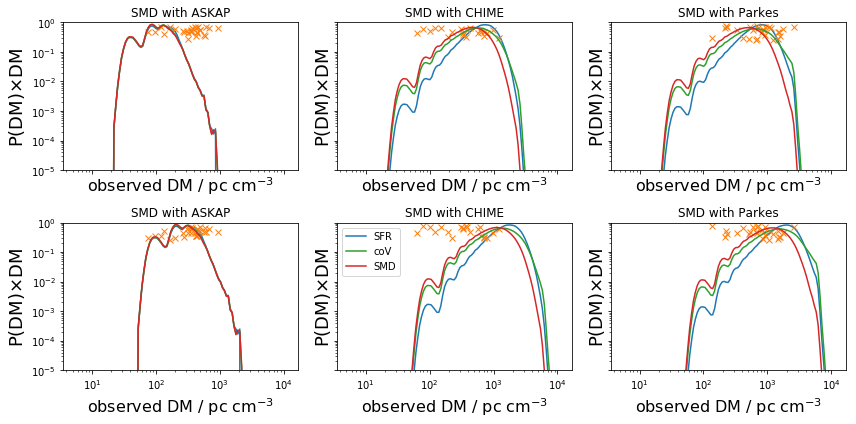

In [173]:
fig, axss = plt.subplots( 2, 3, figsize=(12,6), sharex=True, sharey=True)
for C, axs in zip( Cs[np.array([0,-1])], axss ):
    tmp = scenario_IGM.copy()
    tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]
    print(tmp)
    for telescope, ax in zip( telescopes, axs):
        ax.set_ylim(1e-5,1)
        for population in populations:
            LikelihoodDM( scenario=tmp, telescope=telescope, population=population, plot=True, ax=ax, plot_FRBs=population == populations[0], label=population )
axss[1][1].legend()
fig.tight_layout()

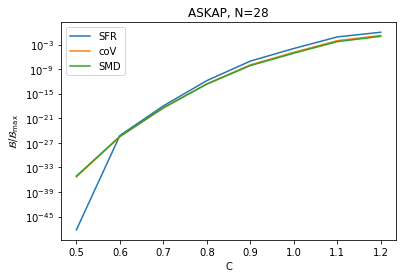

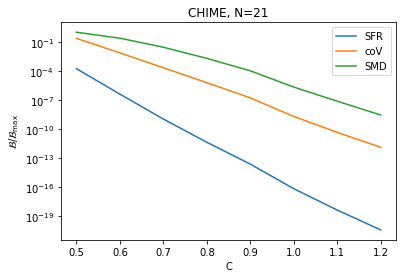

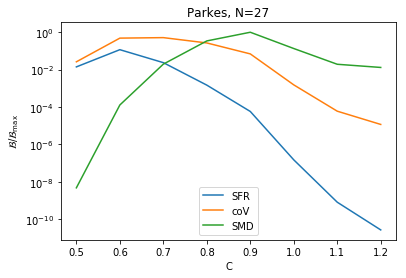

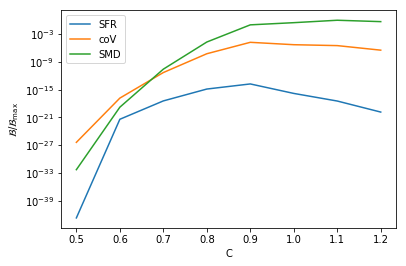

In [146]:
bayes = BayesBaryonContentPopulation(  scenario=scenario_IGM, plot=True, plot_telescopes=True ) 

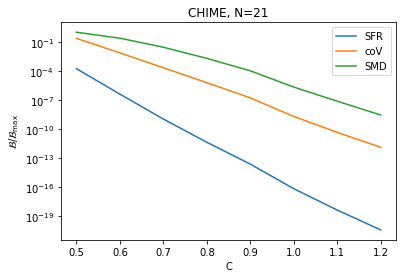

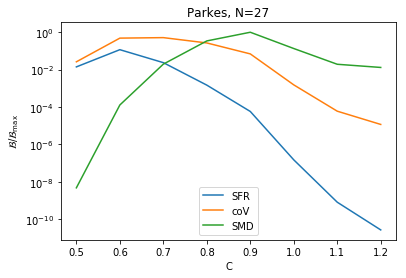

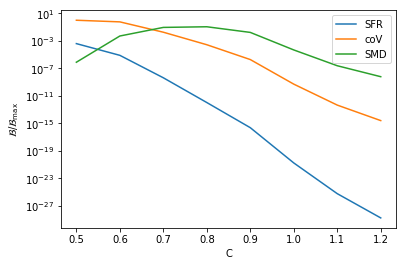

In [174]:
bayes = BayesBaryonContentPopulation(  telescopes=['CHIME','Parkes'], scenario=scenario_IGM, plot=True, plot_telescopes=True ) 

(1e-05, 2)

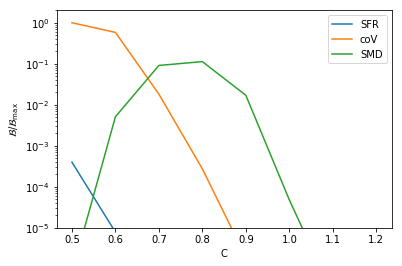

In [176]:
PlotBayes2D( bayes=bayes, x=Cs, xlabel="C", y=populations, graphs=True)
plt.ylim(1e-5,2)

array([[1.00000000e+00, 1.46399205e-02, 1.52622819e-04, 5.16637588e-07,
        3.66218801e-09, 1.61143801e-10, 7.36556412e-13, 2.34460417e-15],
       [2.09868680e+03, 2.53729484e+02, 1.34298193e+01, 2.38463143e-01,
        7.48645599e-03, 7.96463720e-04, 9.48694563e-06, 8.80535877e-08],
       [9.07132074e+03, 6.46365232e+03, 1.01335305e+03, 3.83508914e+01,
        2.17246079e+00, 3.35163102e-01, 5.21514481e-03, 6.46793727e-05]])

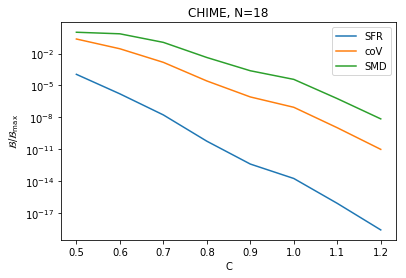

In [158]:
## these are extragalactic DMs observed for the CHIME repeaters (and first is Spitler Burst.)

DMs = [330, 1300, 421, 193, 521, 63, 374, 379, 508, 102, 346, 262, 370, 158, 150, 608, 1239, 257, 340]

BayesBaryonContentPopulationTelescope( DMs=DMs[1:], telescope='CHIME', scenario=scenario_IGM, plot=True )



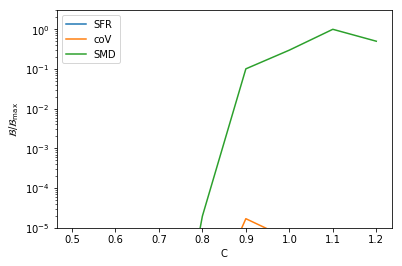

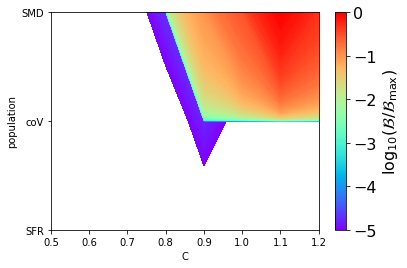

In [143]:
PlotBayes2D( bayes=bayes, x=Cs, y=populations, graphs=True, xlabel='C' )
plt.ylim(1e-5,3)
plt.show()

PlotBayes2D( bayes=bayes, x=Cs, y=populations, plane=True, xlabel='C', ylabel='population', P_min=1e-5 )
plt.show()


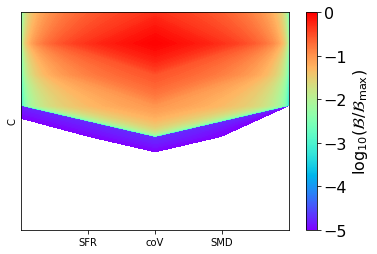

In [42]:
## make contour plot to compare all bayes factors at once
    
x = np.linspace(Cs[0],Cs[-1],len(Cs))
y = np.arange(-1,2)                                
xy_x, xy_y = np.meshgrid( y, x )
                                 
lvl_min = 1e-5
levels = np.linspace( np.log10(lvl_min), 0, 200 )
colors = Rainbow( levels )
levels = 10.**levels
from matplotlib.colors import LogNorm
        
#plt.imshow( bayes[::-1]/bayes.max(), cmap=rainbow, extent=[0,30,0,50], norm=LogNorm( vmin=1e-5) )
#plt.xticks( [5,15,25], populations )
off = float(50)/len(Cs)/2
plt.yticks( np.linspace(off,50-off,len(Cs)), np.round(Cs,1) )
    
#print(bayes/bayes.max())
                                
plt.contourf(xy_x, xy_y, bayes.transpose()/bayes.max(), levels, colors=colors )
plt.xticks( y*2/4, populations )
plt.ylabel('C')
Colorbar( np.log10(levels), label=r"log$_{10}\left(\mathcal{B}/\mathcal{B}_{\rm max}\right)$" )
plt.show()
  

In [121]:
for C in Cs:
    tmp = scenario_IGM.copy()
    tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]
    print( "C = %f" % C )
    try:
        BayesPopulation( tmp )
    except:
        EstimateRedshiftsFRBcat( tmp )
        BayesPopulation( tmp )


C = 0.500000


NameError: name 'PlotBayes' is not defined

C = 0.500000


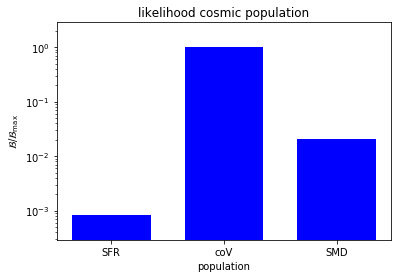

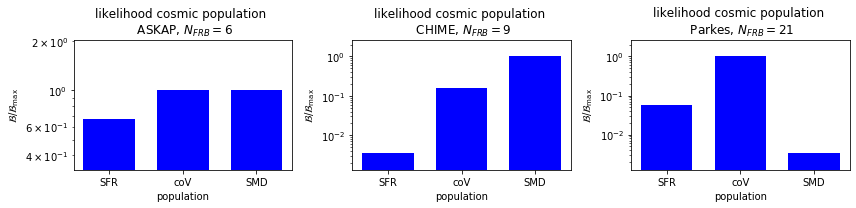

C = 0.600000


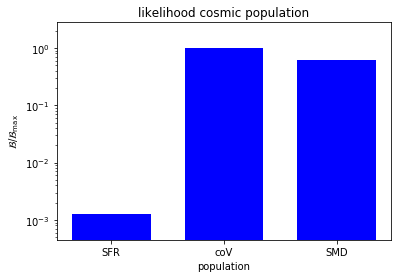

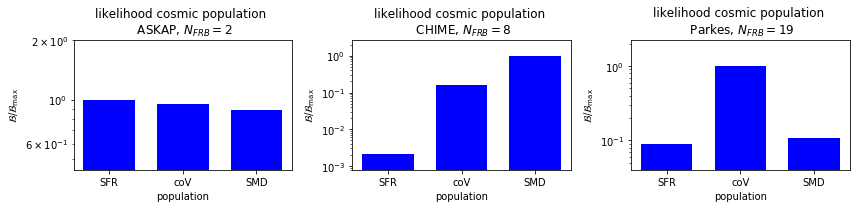

C = 0.700000


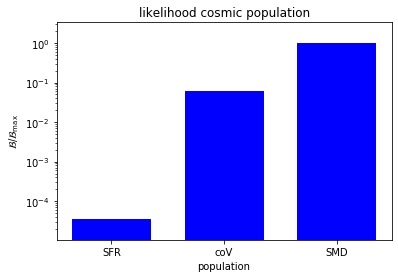

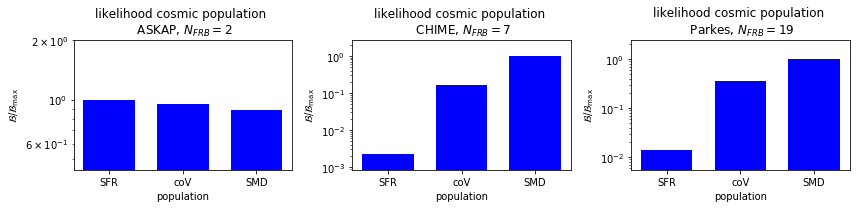

C = 0.800000


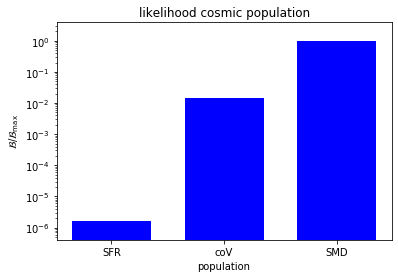

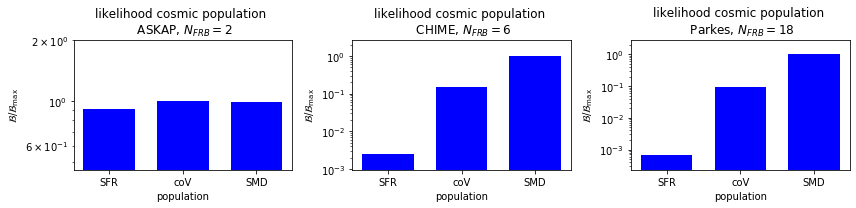

C = 0.900000


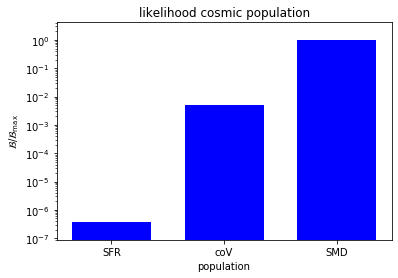

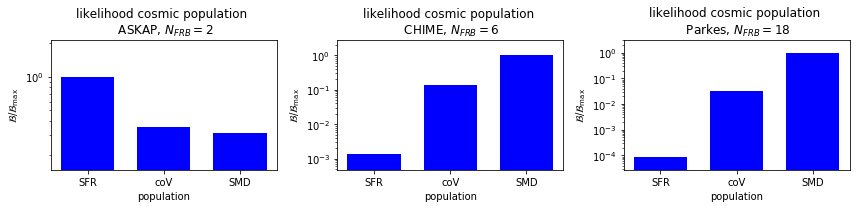

C = 1.000000


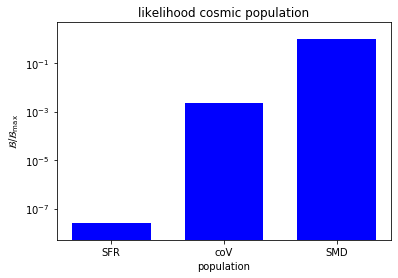

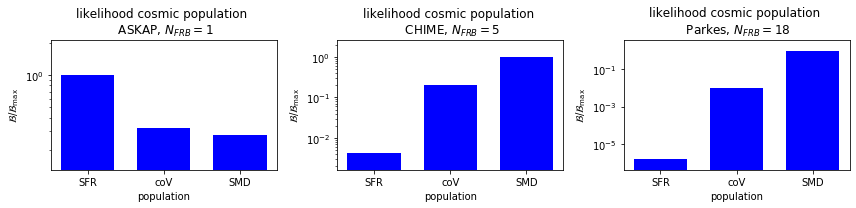

C = 1.100000


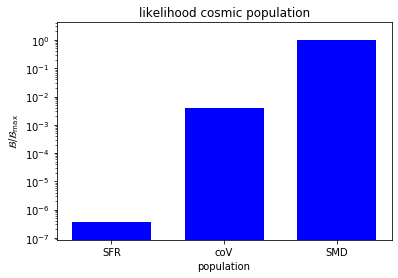

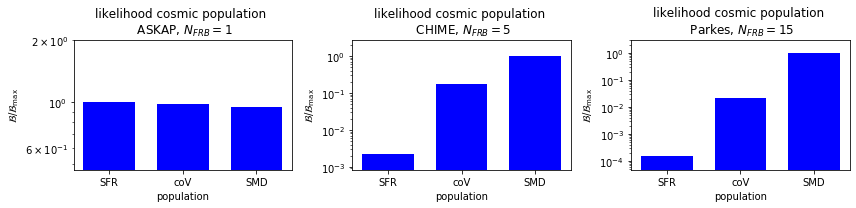

C = 1.200000


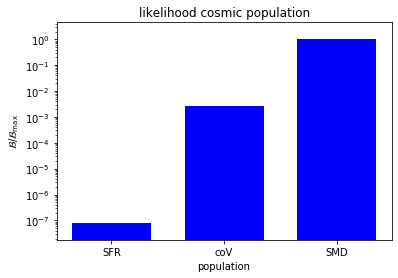

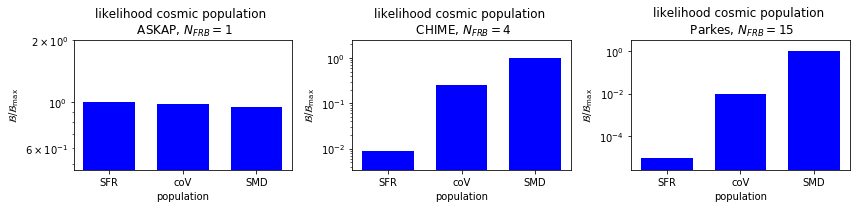

In [8]:
for C in Cs:
    tmp = scenario.copy()
    tmp['IGM'] = ['primordial_C%.0f' % (C*1000)]
    print( "C = %f" % C )
    try:
        BayesPopulation( tmp )
    except:
        FRBcatEstimateRedshifts( tmp )
        BayesPopulation( tmp )


In [31]:
LikelihoodPopulation( redshift_estimates ).shape

(76, 3)

In [141]:
def LikelihoodLikelihood( P1=[], P2=[], x=[] ):
    """ compute the likelihood of of likelihood function P1 according to likelihood function P2, both with identical bin-ranges x"""
    return np.sum(P1*P2*np.diff(x)**2)

0.41657124310074806
0.873506722610822
0.6055014611630457


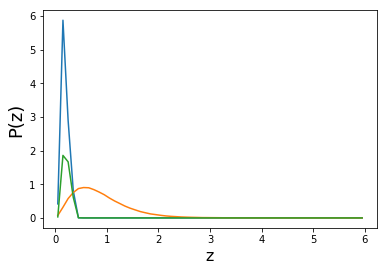

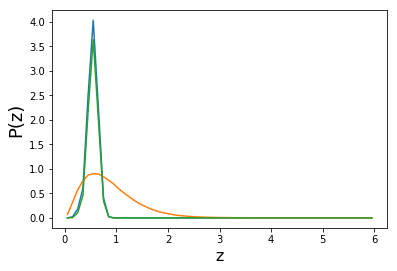

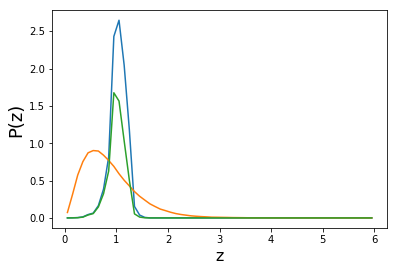

In [132]:
population = 'SMD'
telescope = 'Parkes'
Ps, z = LikelihoodRedshift( DMs=np.array([700,1000,1500]), scenario=scenario, population=population, telescope=telescope )
pi, z =  GetLikelihood_Redshift( population=population, telescope=telescope )

for P in Ps:
    fig, ax = plt.subplots()
    PlotLikelihood( P=P, x=z, measure='z', log=False, ax=ax )
    PlotLikelihood( P=pi, x=z, measure='z', log=False, ax=ax )
    PlotLikelihood( P=P*pi, x=z, measure='z', log=False, ax=ax )
    
    print( LikelihoodLikelihood( P1=P, P2=pi, x=z ))    

    

In [142]:
print( LikelihoodLikelihood( P1=P, P2=P, x=z ), np.sum(P*np.diff(z)))


0.19364439686666432 1.0000000368362767
